In [ ]:
!pip install --upgrade pip > /dev/null
!pip install seaborn > /dev/null
0op       torch > /dev/null

In [ ]:
import os
import glob
import time
import datetime
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt
import random
np.random.seed(42)
random.seed(42)

import importlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import GradScaler, autocast

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay
from generate_anomaly_score import generate_anomaly_score, process_and_save_anomaly_scores
from LSTMAutoencoder import SimpleLSTMAutoencoder

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)


cuda


In [3]:
# load training data
df_all = pd.read_csv('./data/full_data.csv', index_col = 'timestamp')
# df_all['active_power_u1'] = df_all['active_power_u1'].apply(lambda i: 0 if i < 1 else i)
# df_all['active_power_u2'] = df_all['active_power_u2'].apply(lambda i: 0 if i < 1 else i)
df_all['oil_pump_u1'] = df_all[['oil_pump1_u1', 'oil_pump2_u1']].max(axis=1)
df_all['oil_pump_u2'] = df_all[['oil_pump1_u2', 'oil_pump2_u2']].max(axis=1)
df_all

,active_power_u1,oil_pressure_u1,oil_pump1_u1,oil_pump2_u1,active_power_u2,oil_pressure_u2,oil_pump1_u2,oil_pump2_u2,oil_pump_u1,oil_pump_u2
timestamp,,,,,,,,,,
2023-02-01 00:00:00,20.700001,149.699997,1.0,0.0,22.900000,146.699997,0.0,1.0,1.0,1.0
2023-02-01 00:01:00,20.700001,149.449997,1.0,0.0,22.950000,146.700000,0.0,1.0,1.0,1.0
2023-02-01 00:02:00,20.700001,149.447365,1.0,0.0,22.900000,146.707144,0.0,1.0,1.0,1.0
2023-02-01 00:03:00,20.700001,149.457140,1.0,0.0,22.900000,146.683334,0.0,1.0,1.0,1.0
2023-02-01 00:04:00,20.700001,149.511112,1.0,0.0,22.950000,146.705556,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2024-01-31 23:56:00,3.672727,140.182352,0.0,0.0,2.061765,138.482609,0.0,0.0,0.0,0.0
2024-01-31 23:57:00,3.672727,139.775000,0.0,0.0,2.061765,136.750000,0.0,0.0,0.0,0.0
2024-01-31 23:58:00,3.672727,139.507693,0.0,0.0,2.061765,135.350000,0.0,0.0,0.0,0.0


<Axes: xlabel='timestamp'>

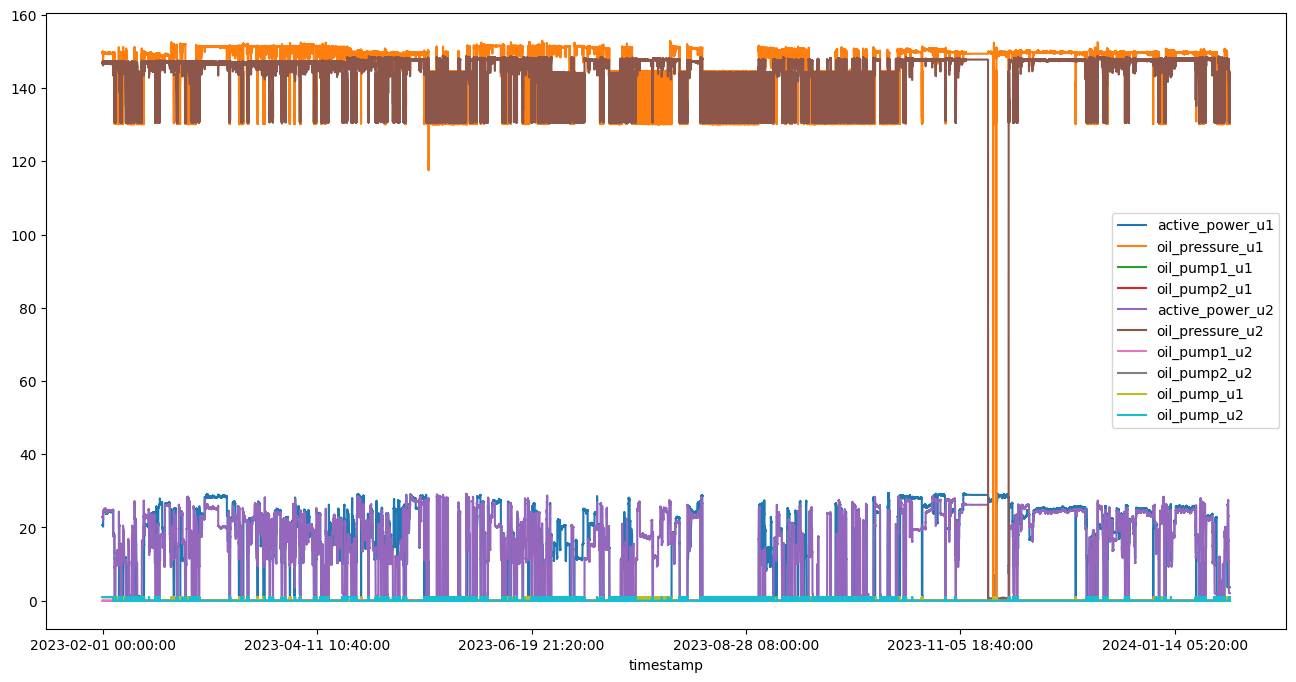

In [4]:
df_all.plot(figsize=(16,8))

In [5]:
X_source = df_all.iloc[:,[0,1,8]].loc['2023-08-14 08:00:00':'2023-09-01 08:00:00']
X_target_full = df_all.iloc[:,[4,5,9]].loc['2023-07-04 14:00:00':'2023-07-07 00:00:00']
X_target_small = df_all.iloc[:,[4,5,9]].loc['2023-06-30 00:00:00':'2023-07-01 00:00:00']
X_source.shape, X_target_full.shape, X_target_small.shape

((25921, 3), (3481, 3), (1441, 3))

In [6]:
X_source.iloc[:,:].loc['2023-08-14 08:00:00':'2023-08-14 20:00:00'].to_csv('./data/test_u1.csv')

In [7]:
X_target_small.iloc[:,:].loc['2023-06-30 00:00:00':'2023-06-30 12:00:00'].to_csv('./data/test_u2.csv')

<Axes: xlabel='timestamp'>

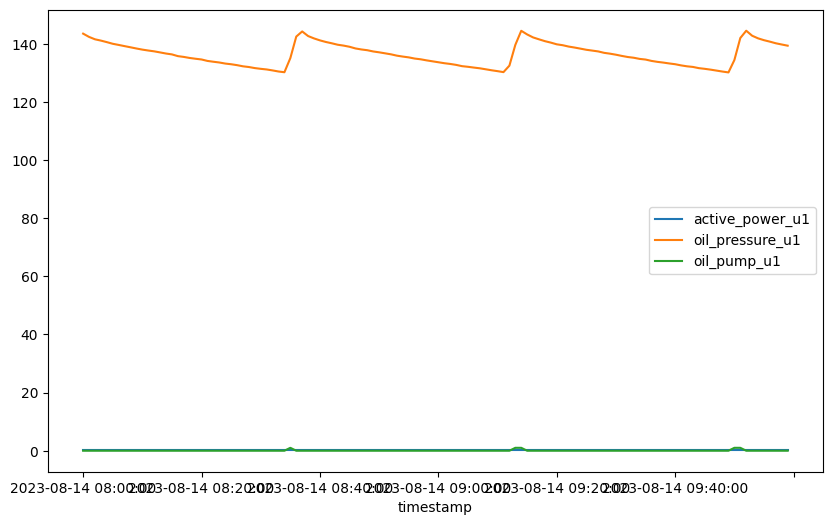

In [8]:
X_source.iloc[:120,:].plot(figsize=(10,6))

<Axes: xlabel='timestamp'>

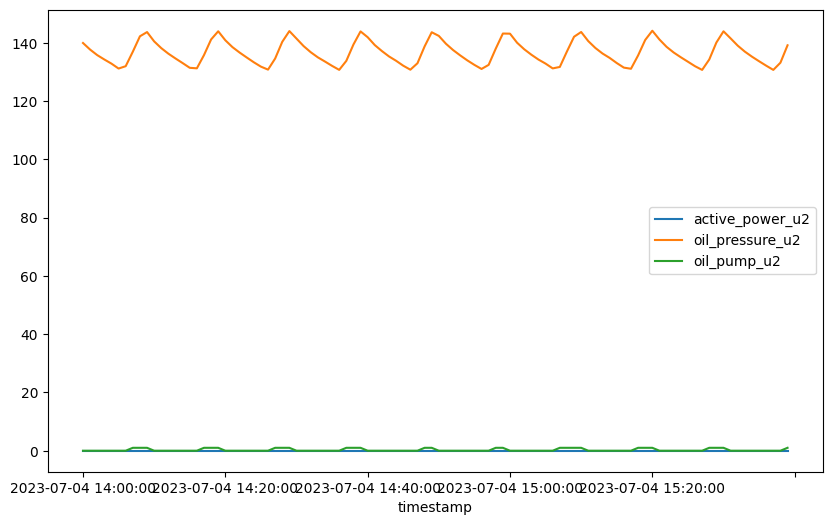

In [9]:
X_target_full.iloc[:100,:].plot(figsize=(10,6))

<Axes: xlabel='timestamp'>

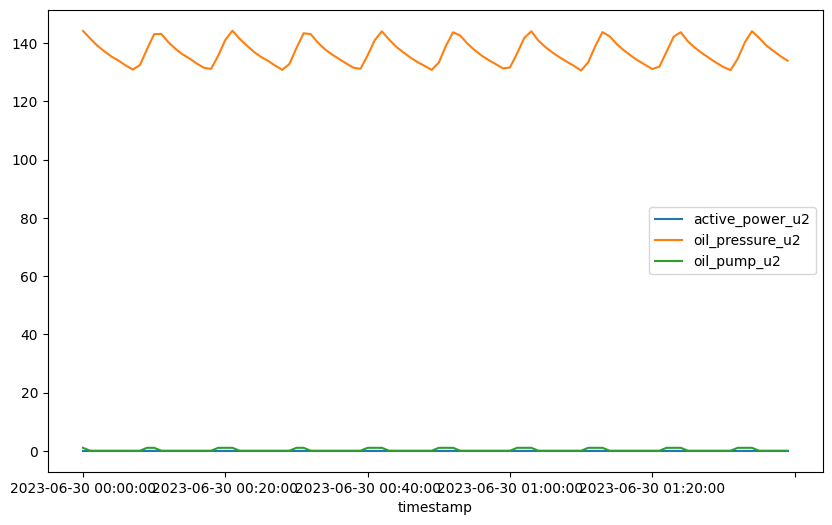

In [10]:
X_target_small.iloc[:100,:].plot(figsize=(10,6))

In [11]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
def estimate_period_length(data):
    peaks, _ = find_peaks(data)

    if len(peaks) > 1:
        peak_distances = np.diff(peaks)
        period = np.mean(peak_distances)
    else:
        period = None
        
    print(f"period_length: {period}")
    
estimate_period_length(X_source.iloc[:,1])
estimate_period_length(X_target_full.iloc[:,1])
estimate_period_length(X_target_small.iloc[:,1])

period_length: 58.56689342403628
period_length: 10.140350877192983
period_length: 10.379562043795621


In [12]:
df_non_scaled = df_all.copy(deep=True)
display(df_non_scaled)

,active_power_u1,oil_pressure_u1,oil_pump1_u1,oil_pump2_u1,active_power_u2,oil_pressure_u2,oil_pump1_u2,oil_pump2_u2,oil_pump_u1,oil_pump_u2
timestamp,,,,,,,,,,
2023-02-01 00:00:00,20.700001,149.699997,1.0,0.0,22.900000,146.699997,0.0,1.0,1.0,1.0
2023-02-01 00:01:00,20.700001,149.449997,1.0,0.0,22.950000,146.700000,0.0,1.0,1.0,1.0
2023-02-01 00:02:00,20.700001,149.447365,1.0,0.0,22.900000,146.707144,0.0,1.0,1.0,1.0
2023-02-01 00:03:00,20.700001,149.457140,1.0,0.0,22.900000,146.683334,0.0,1.0,1.0,1.0
2023-02-01 00:04:00,20.700001,149.511112,1.0,0.0,22.950000,146.705556,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2024-01-31 23:56:00,3.672727,140.182352,0.0,0.0,2.061765,138.482609,0.0,0.0,0.0,0.0
2024-01-31 23:57:00,3.672727,139.775000,0.0,0.0,2.061765,136.750000,0.0,0.0,0.0,0.0
2024-01-31 23:58:00,3.672727,139.507693,0.0,0.0,2.061765,135.350000,0.0,0.0,0.0,0.0


# Standardization

In [37]:
df_all.iloc[0, 0].dtype

dtype('float64')

In [ ]:
#standardization
# scaler = StandardScaler()
scaler = MinMaxScaler()
combined_data = np.vstack([df_non_scaled.loc[:,['oil_pressure_u1']], df_non_scaled.loc[:,['oil_pressure_u1']]])
scaler.fit_transform(combined_data)
# df_all.iloc[:,[5]] = scaler.transform(df_all.loc[:,[5]])
# df_all.iloc[:,[1]] = scaler.transform(df_all.iloc[:,[1]])
oil_pressure_columns = df_all.columns[df_all.columns.str.startswith('oil_pressure')].values
for column in oil_pressure_columns:
    df_all.loc[:, column] = scaler.transform(df_all.loc[:, column].values.reshape(-1,1)).flatten()
df_all = df_all.drop(columns=['oil_pump1_u1', 'oil_pump2_u1','oil_pump1_u2','oil_pump2_u2'])
df_all

,active_power_u1,oil_pressure_u1,active_power_u2,oil_pressure_u2,oil_pump_u1,oil_pump_u2
timestamp,,,,,,
2023-02-01 00:00:00,20.700001,0.978726,22.900000,0.959099,1.0,1.0
2023-02-01 00:01:00,20.700001,0.977091,22.950000,0.959099,1.0,1.0
2023-02-01 00:02:00,20.700001,0.977073,22.900000,0.959146,1.0,1.0
2023-02-01 00:03:00,20.700001,0.977137,22.900000,0.958990,1.0,1.0
2023-02-01 00:04:00,20.700001,0.977491,22.950000,0.959136,1.0,1.0
...,...,...,...,...,...,...
2024-01-31 23:56:00,3.672727,0.916459,2.061765,0.905339,0.0,0.0
2024-01-31 23:57:00,3.672727,0.913794,2.061765,0.894004,0.0,0.0
2024-01-31 23:58:00,3.672727,0.912045,2.061765,0.884844,0.0,0.0


In [14]:
# filter the non-producing period after standardization
X_source = df_all.iloc[:,[0,1,4]].loc['2023-08-16 08:00:00':'2023-09-01 08:00:00']
X_source_val = df_all.iloc[:,[0,1,4]].loc['2023-08-15 08:00:00':'2023-08-16 08:00:00']

X_target_full = df_all.iloc[:,[2,3,5]].loc['2023-07-03 14:00:00':'2023-07-07 00:00:00']
X_target_small = df_all.iloc[:,[2,3,5]].loc['2023-06-30 00:00:00':'2023-07-01 00:00:00']
X_target_val = df_all.iloc[:,[2,3,5]].loc['2023-07-01 00:00:00':'2023-07-02 00:00:00']
X_source.shape, X_source_val.shape, X_target_full.shape, X_target_small.shape, X_target_val.shape

((23041, 3), (1441, 3), (4921, 3), (1441, 3), (1441, 3))

<Axes: xlabel='timestamp'>

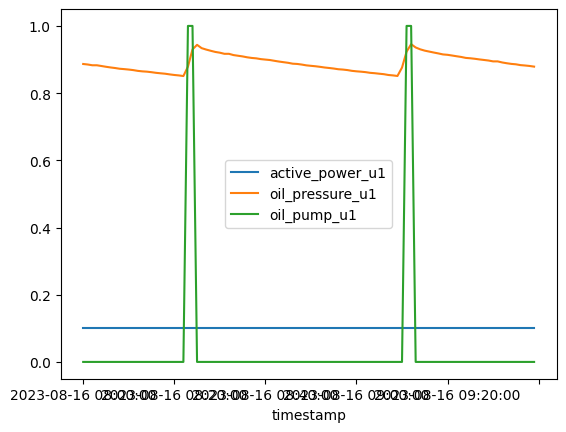

In [16]:
X_source.iloc[:100,:].plot()

<Axes: xlabel='timestamp'>

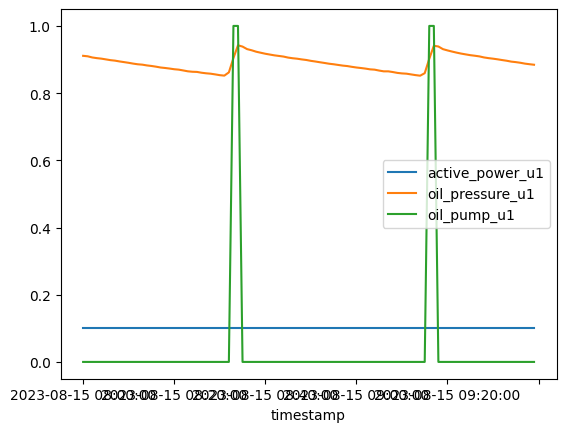

In [17]:
X_source_val.iloc[:100,:].plot()

<Axes: xlabel='timestamp'>

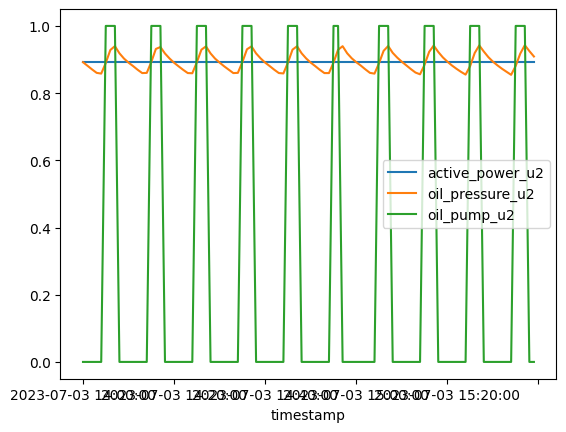

In [18]:
X_target_full.iloc[:100,:].plot()

<Axes: xlabel='timestamp'>

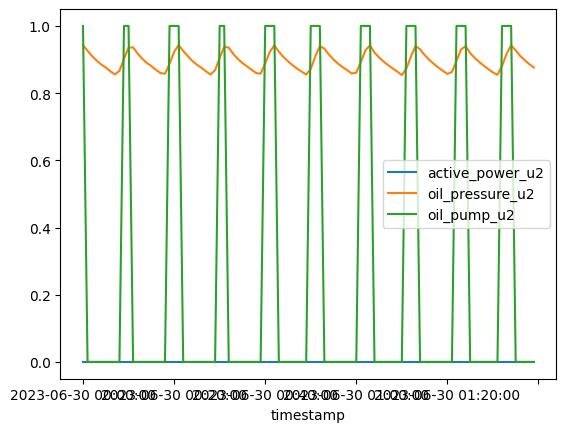

In [19]:
X_target_small.iloc[:100,:].plot()

<Axes: xlabel='timestamp'>

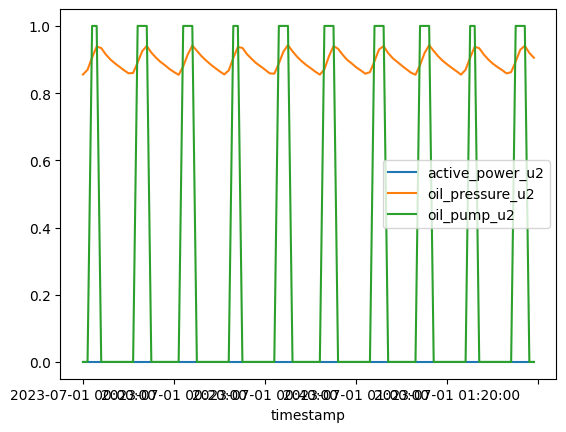

In [20]:
X_target_val.iloc[:100,:].plot()

In [14]:
# X_source = df_all.iloc[:,:4].loc['2023-02-01 00:00:00 ':'2024-02-01 00:00:00']
# X_target_full = df_all.iloc[:,4:].loc['2023-02-01 00:00:00 ':'2024-01-01 00:00:00']
# X_target_small = df_all.iloc[:,4:].loc['2024-01-01 00:00:00':'2024-02-01 00:00:00']
# X_source.shape, X_target_full.shape, X_target_small.shape

In [21]:
#resample data for smaller datasets
def resample_data(df, new_frequency='1min'):
    # Ensure that the index is a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Resample the data to the specified frequency, using the mean as the aggregation method
    resampled_df = df.resample(new_frequency).mean()
    
    return resampled_df


# X_source = resample_data(X_source)
# X_target_full = resample_data(X_target_full)
# X_target_small = resample_data(X_target_small)
# X_source.shape, X_target_full.shape, X_target_small.shape

In [22]:
def prepare_data(X, sequence_length):
    # Convert the input dataframe to a tensor
    X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
    
    # Calculate the number of sequences that can be created
    num_samples = X_tensor.shape[0] - sequence_length + 1
    num_features = X_tensor.shape[1]
    
    # Create a view with sliding windows of size (sequence_length, num_features)
    X_sequences = torch.zeros((num_samples, sequence_length, num_features), dtype=torch.float32)
    for i in range(num_samples):
        X_sequences[i] = X_tensor[i:i + sequence_length]
    
    # Create a dataset
    dataset = TensorDataset(X_sequences)
    print(X_sequences.shape)
    return dataset



In [23]:
# Pretrain function
# gradscaler = GradScaler(init_scale=2.0)

#define different weights for each signal (active_power, oil_pressure, pump)
loss_weights = torch.tensor([0.1, 1.0, 1.2], dtype=torch.float32).to(device) 

def weighted_mse_loss(output, target, loss_weights):
    mse = (output - target) ** 2
    weighted_mse = mse * loss_weights  # Apply column-wise weights
    return weighted_mse.mean()

def pretrain(model, data, val_data, save_path, epochs=100, batch_size=64, learning_rate=1e-4):  # Decreased learning rate for more stable training
    # optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-6)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    
    # criterion = nn.SmoothL1Loss()  # Changed to Huber Loss for more robustness to outliers
    # criterion = nn.MSELoss()  # Changed to MSE Loss for better reconstruction
    
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
    
    best_loss = float('inf')
    patience = 100  # Increased patience to allow more epochs before early stopping
    counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            output = model(batch)
            # loss = criterion(output, batch)
            loss = weighted_mse_loss(output, batch, loss_weights)
            loss.backward()
            optimizer.step()            
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(dataloader)
  
        val_loss = 0      
        model.eval()
        with torch.no_grad():
            for val_batch in val_loader:
                val_batch = val_batch[0].to(device)
                val_output = model(val_batch)
                val_loss += weighted_mse_loss(val_output, val_batch, loss_weights).item()
        val_loss /= len(val_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"Pretrain Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss}, Total Loss: {total_loss}, Val Loss:{val_loss}")
        
        # scheduler.step(val_loss)
        
        # Early Stopping Check
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            
            # Save the model with the best performance
            torch.save(model.state_dict(), save_path)
            # print(f"New best model saved with loss {best_loss:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break
                
    model.load_state_dict(torch.load(save_path, weights_only=True))

# Fine-tune function
def finetune(model, data, val_data, save_path, epochs=100, batch_size=64, learning_rate=1e-4, train_last_layer_only=True):  # Decreased learning rate for fine-tuning
    if train_last_layer_only:
        for name, param in model.named_parameters():
            if 'encoder_lstm' in name:
                param.requires_grad = False
    pretrain(model, data, val_data, save_path, epochs, batch_size, learning_rate)


# Training

In [25]:
# Hyperparameters

hidden_dim = 64
num_layers = 2
# dropout = 0.0

In [27]:
# -------------------- Training with Transfer Learning: X_source -> X_target_small--------------------
torch.cuda.empty_cache()
import LSTMAutoencoder
importlib.reload(LSTMAutoencoder)
from LSTMAutoencoder import SimpleLSTMAutoencoder

sequence_length = 60
model_save_path="./models/lstm_TL_u1.pth"
source_dataset = prepare_data(X_source.iloc[:,:], sequence_length)
source_val_dataset = prepare_data(X_source_val.iloc[:100,:], sequence_length)
target_small_dataset = prepare_data(X_target_small.iloc[:100,:], sequence_length)
target_val_dataset = prepare_data(X_target_val.iloc[:100,:], sequence_length)

input_dim = [batch[0][1].shape for batch in source_dataset][0][0]

# Initialize LSTM Autoencoder
# lstm_autoencoder_1 = LSTMAutoencoder(input_dim, hidden_dim, num_layers, dropout).to(device)
lstm_autoencoder_1 = SimpleLSTMAutoencoder(input_dim, hidden_dim, sequence_length, num_layers).to(device)

# Pretrain on X_source
pretrain(lstm_autoencoder_1, source_dataset, source_val_dataset, epochs=800, learning_rate=1e-3, batch_size=64, save_path=model_save_path)

# Fine-tune on X_target_small
finetune(lstm_autoencoder_1, target_small_dataset, target_val_dataset, epochs=500, train_last_layer_only=True, save_path=model_save_path)

# Save model
torch.save(lstm_autoencoder_1, model_save_path)
print('model saved')

torch.Size([22982, 60, 3])
torch.Size([41, 60, 3])
torch.Size([41, 60, 3])
torch.Size([41, 60, 3])
Pretrain Epoch 10/800, Train Loss: 0.010111852730106976, Total Loss: 3.6402669828385115, Val Loss:0.018325626850128174
Pretrain Epoch 20/800, Train Loss: 0.01009805353047947, Total Loss: 3.6352992709726095, Val Loss:0.018442433327436447
Pretrain Epoch 30/800, Train Loss: 0.010104274752342867, Total Loss: 3.637538910843432, Val Loss:0.01836073026061058
Pretrain Epoch 40/800, Train Loss: 0.01009482146344251, Total Loss: 3.634135726839304, Val Loss:0.01838032342493534
Pretrain Epoch 50/800, Train Loss: 0.010104994121421542, Total Loss: 3.6377978837117553, Val Loss:0.018339551985263824
Pretrain Epoch 60/800, Train Loss: 0.010097193899047044, Total Loss: 3.6349898036569357, Val Loss:0.018368374556303024
Pretrain Epoch 70/800, Train Loss: 0.010094443248170945, Total Loss: 3.6339995693415403, Val Loss:0.018397385254502296
Pretrain Epoch 80/800, Train Loss: 0.010099828637774207, Total Loss: 3.635

In [28]:
# -------------------- Training on Full Target Data: X_target_full -> X_target_small --------------------

# Initialize LSTM Autoencoder
sequence_length = 15
model_save_path="./models/lstm_TL_u2.pth"

target_small_dataset = prepare_data(X_target_small.iloc[:100,:], sequence_length)
target_val_dataset = prepare_data(X_target_val.iloc[:100,:], sequence_length)
target_full_dataset = prepare_data(X_target_full.iloc[:,:], sequence_length)

# lstm_autoencoder_2 = LSTMAutoencoder(input_dim, hidden_dim, num_layers, dropout).to(device)
lstm_autoencoder_2 = SimpleLSTMAutoencoder(input_dim, hidden_dim, sequence_length, num_layers).to(device)

# Pretrain on X_target_full
pretrain(lstm_autoencoder_2, target_full_dataset, target_val_dataset, epochs=500, learning_rate=1e-3, batch_size=64, save_path=model_save_path)

# Fine-tune on X_target_small
finetune(lstm_autoencoder_2, target_small_dataset, target_val_dataset, epochs=300, train_last_layer_only=True, save_path=model_save_path)

# Save model
torch.save(lstm_autoencoder_2, model_save_path)
print('model saved')

torch.Size([86, 15, 3])
torch.Size([86, 15, 3])
torch.Size([4907, 15, 3])


Pretrain Epoch 10/500, Train Loss: 0.0036304646440745367, Total Loss: 0.27954577759373933, Val Loss:0.0017079069511964917
Pretrain Epoch 20/500, Train Loss: 0.0007686397512806217, Total Loss: 0.05918526084860787, Val Loss:0.0008336177561432123
Pretrain Epoch 30/500, Train Loss: 0.00037851844205182385, Total Loss: 0.029145920037990436, Val Loss:0.00024938689603004605
Pretrain Epoch 40/500, Train Loss: 0.0003076836055933873, Total Loss: 0.02369163763069082, Val Loss:0.00018177933088736609
Pretrain Epoch 50/500, Train Loss: 0.004480471890102225, Total Loss: 0.34499633553787135, Val Loss:0.0008407402783632278
Pretrain Epoch 60/500, Train Loss: 0.004756368216287417, Total Loss: 0.36624035265413113, Val Loss:0.00040189758874475956
Pretrain Epoch 70/500, Train Loss: 0.00019282497716583796, Total Loss: 0.014847523241769522, Val Loss:0.00012994101052754559
Pretrain Epoch 80/500, Train Loss: 0.0005239811642760677, Total Loss: 0.04034654964925721, Val Loss:0.0002170512598240748
Pretrain Epoch 90/

In [29]:
# -------------------- Training without Transfer Learning: X_target_small only--------------------

# Initialize LSTM Autoencoder
sequence_length = 15
model_save_path="./models/lstm_small.pth"
lstm_autoencoder_3 = SimpleLSTMAutoencoder(input_dim, hidden_dim, sequence_length, num_layers).to(device)

# Train directly on X_target_small without pretraining
pretrain(lstm_autoencoder_3, target_small_dataset, target_val_dataset, epochs=200, learning_rate=1e-3, batch_size=64, save_path=model_save_path)

# Save model
torch.save(lstm_autoencoder_3, model_save_path)
print('model saved')

Pretrain Epoch 10/200, Train Loss: 0.0967431589961052, Total Loss: 0.1934863179922104, Val Loss:0.08410592004656792
Pretrain Epoch 20/200, Train Loss: 0.07928533852100372, Total Loss: 0.15857067704200745, Val Loss:0.08038507774472237
Pretrain Epoch 30/200, Train Loss: 0.07912155985832214, Total Loss: 0.1582431197166443, Val Loss:0.07913517579436302
Pretrain Epoch 40/200, Train Loss: 0.07785998657345772, Total Loss: 0.15571997314691544, Val Loss:0.0784793347120285
Pretrain Epoch 50/200, Train Loss: 0.07913298159837723, Total Loss: 0.15826596319675446, Val Loss:0.0791686549782753
Pretrain Epoch 60/200, Train Loss: 0.0788714699447155, Total Loss: 0.157742939889431, Val Loss:0.07873478531837463
Pretrain Epoch 70/200, Train Loss: 0.07906066253781319, Total Loss: 0.15812132507562637, Val Loss:0.07833878695964813
Pretrain Epoch 80/200, Train Loss: 0.07943157106637955, Total Loss: 0.1588631421327591, Val Loss:0.07764510437846184
Pretrain Epoch 90/200, Train Loss: 0.07808684930205345, Total Los

# Generate Anomaly Scores

In [40]:
import importlib
import generate_anomaly_score
importlib.reload(generate_anomaly_score)
from generate_anomaly_score import process_and_save_anomaly_scores

# load test data
root_dir = './data'

data_files = ['inter_leakage.csv', 'pump_failure.csv', 'test_u1.csv', 'test_u2.csv']
# data_files = ['test_u1.csv', 'test_u2.csv']

# Run the anomaly detection and save results
model_files = ['./models/lstm_TL_u1.pth']
data_with_anomaly_scores = process_and_save_anomaly_scores(data_files, model_files, root_dir, scaler, sequence_length=60)

model_files = ['./models/lstm_TL_u2.pth', './models/lstm_small.pth']
data_with_anomaly_scores = process_and_save_anomaly_scores(data_files, model_files, root_dir, scaler, sequence_length=15)

Anomaly scores saved to ./results/inter_leakage_lstm_TL_u1_scored.csv
Anomaly scores saved to ./results/pump_failure_lstm_TL_u1_scored.csv
Anomaly scores saved to ./results/test_u1_lstm_TL_u1_scored.csv
Anomaly scores saved to ./results/test_u2_lstm_TL_u1_scored.csv
Anomaly scores saved to ./results/inter_leakage_lstm_TL_u2_scored.csv
Anomaly scores saved to ./results/pump_failure_lstm_TL_u2_scored.csv
Anomaly scores saved to ./results/test_u1_lstm_TL_u2_scored.csv
Anomaly scores saved to ./results/test_u2_lstm_TL_u2_scored.csv
Anomaly scores saved to ./results/inter_leakage_lstm_small_scored.csv
Anomaly scores saved to ./results/pump_failure_lstm_small_scored.csv
Anomaly scores saved to ./results/test_u1_lstm_small_scored.csv
Anomaly scores saved to ./results/test_u2_lstm_small_scored.csv


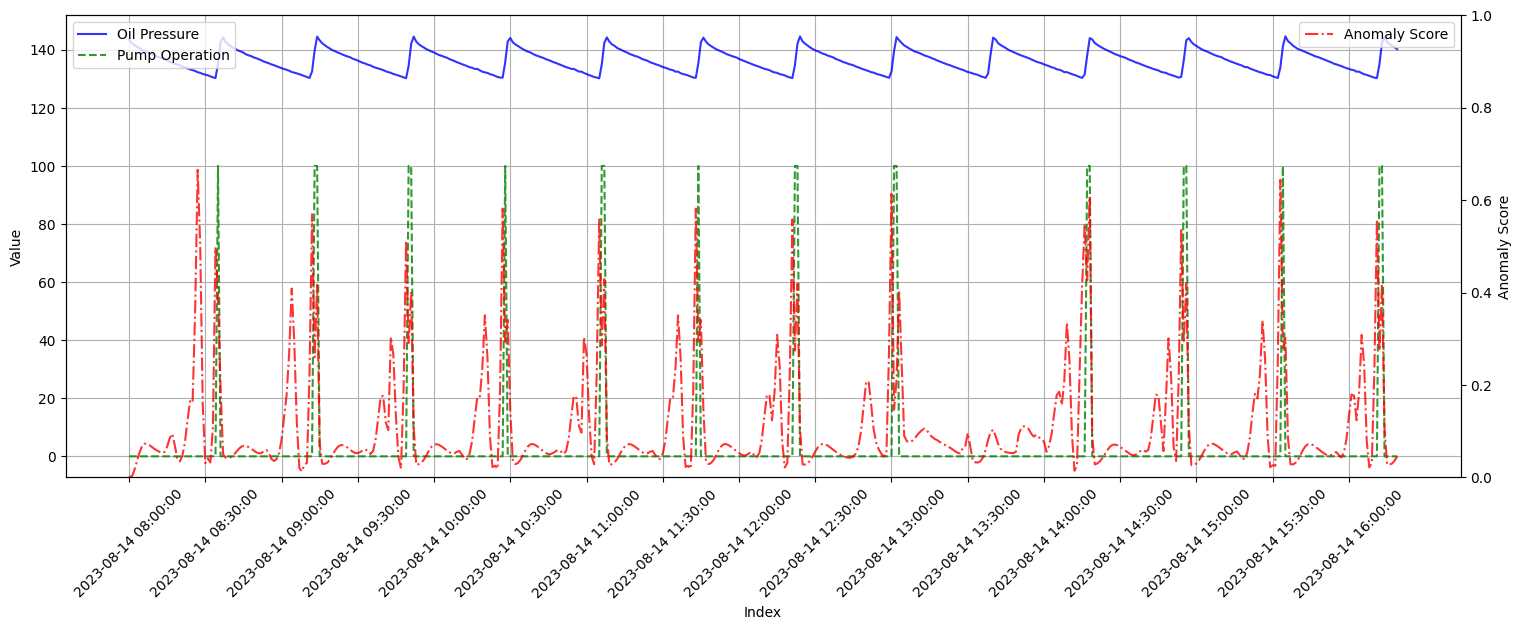

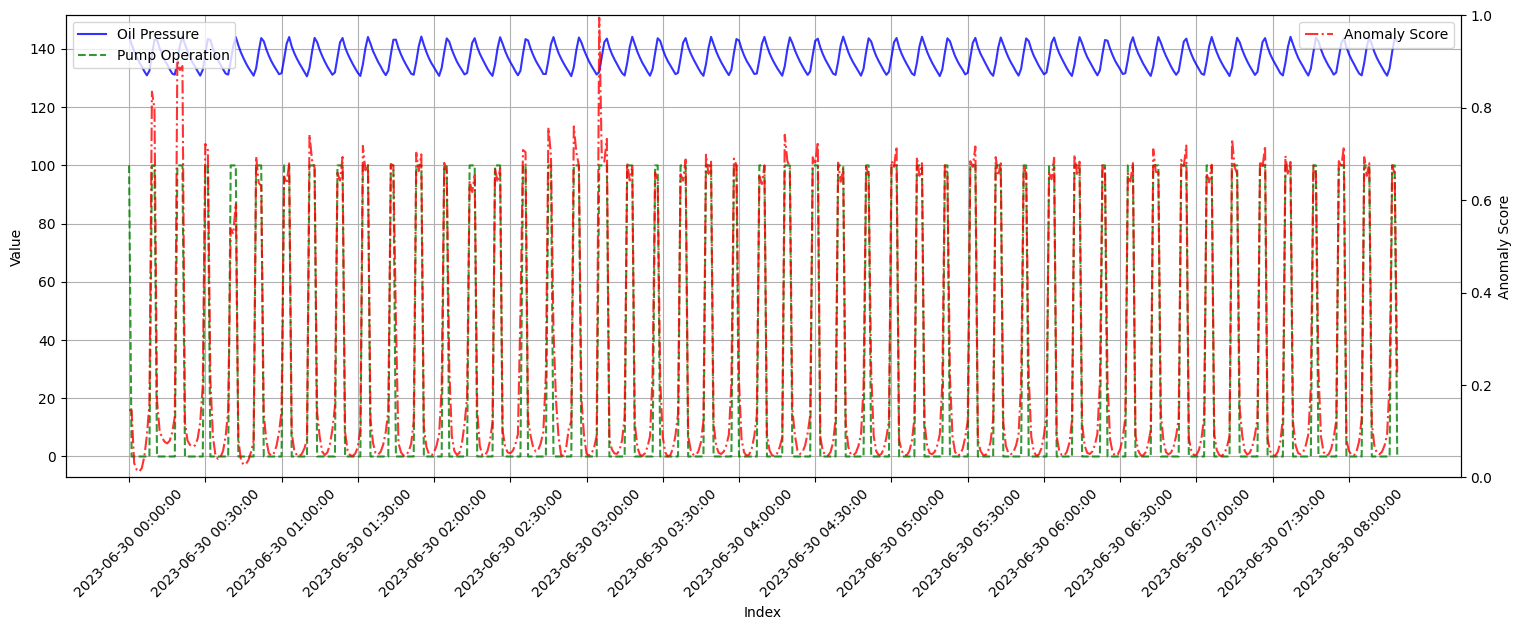

In [44]:
# data = pd.read_csv('./results/test_u1_lstm_TL_u1_scored.csv', index_col='timestamp')[:500]
# data = data_with_anomaly_scores[:500]

def plot_test_training(data):
    fig, ax1 = plt.subplots(figsize=(18, 6))
    # Plot Oil Pressure and Pump Operation on the left y-axis
    ax1.plot(data.index, data.iloc[:,1], label='Oil Pressure', color='b', alpha=0.8)
    ax1.plot(data.index, data.iloc[:,2].apply(lambda x: 100 if x == 1 else x), label='Pump Operation', color='g', linestyle='--', alpha=0.8)
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Value')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    plt.xticks(data.index[::30], rotation=45)

    # Plot Anomaly Score on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['anomaly_score'], label='Anomaly Score', color='r', linestyle='-.', alpha=0.8)
    ax2.set_ylabel('Anomaly Score')
    ax2.legend(loc='upper right')
    plt.ylim(0,1)

    plt.show()
    
plot_test_training(pd.read_csv('./results/test_u1_lstm_TL_u1_scored.csv', index_col='timestamp')[:500])
plot_test_training(pd.read_csv('./results/test_u2_lstm_TL_u1_scored.csv', index_col='timestamp')[:500])

In [45]:
#visualize some reconstruction results of training data
for idx, batch in enumerate(target_full_dataset):
    if idx % sequence_length == 0:
        lstm_autoencoder_2.eval()
        with torch.no_grad():
            batch = batch[0].to(device).reshape(1,sequence_length,input_dim)
            output = lstm_autoencoder_2(batch).cpu().numpy()
            array1 = batch[0].cpu().numpy()[:,[1,2]]
            array2 = output[:,:,[1,2]][0]
            # print("in", array1, '\n out', array2)
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            axes[0].plot(array1[:, 0], label='input - Oil Pressure', marker='o')
            axes[0].plot(array2[:, 0], label='output - Oil Pressure', marker='x')
            axes[0].set_title('Comparison of Column 1')
            axes[0].set_xlabel('Index')
            axes[0].set_ylabel('Value')
            axes[0].legend()

            # Plot for the second column
            axes[1].plot(array1[:, 1], label='input - Pump Operation', marker='o')
            axes[1].plot(array2[:, 1], label='output - Pump Operation', marker='x')
            axes[1].set_title('Comparison of Column 2')
            axes[1].set_xlabel('Index')
            axes[1].set_ylabel('Value')
            axes[1].legend()
            plt.ylim(-1.5,1.5)

            plt.tight_layout()
            plt.show()

            if idx > 3 * sequence_length:
                break

NameError: name 'target_full_dataset' is not defined